In [2]:
import numpy as np
import h5py
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense 
from keras.layers import ConvLSTM2D, Conv2D, MaxPooling2D
from keras.layers import MaxPooling1D, Conv1D
from keras.layers import GRU, LSTM, BatchNormalization
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.utils import to_categorical
from keras.layers import Activation
from keras.layers import Dropout

from keras import regularizers

from sklearn.metrics import confusion_matrix
import itertools

from UtilNNDL import create_window_data
from UtilNNDL import plot_hist
from UtilNNDL import prepare_data
from UtilNNDL import plot_confusion_matrix

A01T = h5py.File('/home/carla/Downloads/project_datasets/project_datasets/A01T_slice.mat','r')
data = np.copy(A01T['image'])
labels = np.copy(A01T['type'])
labels = labels[0,0:data.shape[0]:1]
labels = np.asarray(labels, dtype=np.int32)

a = data[:56]
b = data[57:]
data = np.vstack((a,b))
a = labels[:56]
b = labels[57:]
labels = np.hstack((a,b))
#enc = OneHotEncoder()
#enc_labels = enc.fit_transform(labels.reshape(-1,1)).toarray()
enc_labels = to_categorical(labels-769, num_classes=4)
print(enc_labels)

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

Using TensorFlow backend.


[[ 0.  0.  0.  1.]
 [ 0.  0.  1.  0.]
 [ 0.  1.  0.  0.]
 ..., 
 [ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 1.  0.  0.  0.]]


In [3]:
file_path = '/home/carla/Downloads/project_datasets/project_datasets/'
train_data, test_data, train_labels, test_labels = prepare_data(file_path, 
                                                                num_test_samples = 50, 
                                                                verbose= False, 
                                                                return_all=True,
                                                                num_files =1)
print train_data.shape
print train_labels.shape
print test_data.shape
print test_labels.shape

(237, 22, 1000)
(237, 4)
(50, 22, 1000)
(50, 4)


In [7]:
bs, t, f = data.shape
np.random.seed(42)
shuffle = np.random.choice(bs,bs,replace=False)

data = data[:,0:22,:]

train_samples = data.shape[0]-50
train_data = data[shuffle[:train_samples],:,:]
train_labels = enc_labels[shuffle[:train_samples]]
test_data = data[shuffle[train_samples:],:,:]
test_labels = enc_labels[shuffle[train_samples:]]
print train_data.shape
print test_data.shape

(237, 22, 1000)
(50, 22, 1000)


In [3]:
#Experimental, try flipping the data in time
train_data = np.vstack([train_data, train_data[:,:,::-1]])
test_data = np.vstack([test_data, test_data[:,:,::-1]]) 
print train_data.shape
print test_data.shape
train_labels = np.vstack([train_labels, train_labels])
test_labels = np.vstack([test_labels, test_labels])
print train_labels.shape
print test_labels .shape 

(474, 22, 1000)
(100, 22, 1000)
(474, 4)
(100, 4)


In [4]:
#Augment the data into a bigger set by windowing
train_data_sliced, train_labels_sliced = create_window_data(train_data, train_labels, windows=10)
test_data_sliced, test_labels_sliced = create_window_data(test_data, test_labels, windows=10)
print train_data_sliced.shape
print train_labels_sliced.shape
print test_data_sliced.shape
print test_labels_sliced.shape 

(2370, 22, 512)
(2370, 4)
(500, 22, 512)
(500, 4)


In [4]:
test_data_sliced = test_data_sliced[:500,:]
test_labels_sliced = test_labels_sliced[:500,:]
print test_data_sliced.shape
print test_labels_sliced.shape 

(500, 22, 512)
(500, 4)


In [5]:
traindata2d = train_data_sliced.reshape(train_data_sliced.shape[0], train_data_sliced.shape[2], train_data_sliced.shape[1], 1)
testdata2d = test_data_sliced.reshape(test_data_sliced.shape[0], test_data_sliced.shape[2], test_data_sliced.shape[1], 1)
print traindata2d.shape
print testdata2d.shape

(2370, 512, 22, 1)
(500, 512, 22, 1)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 491, 22, 40)       920       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 491, 1, 40)        35240     
_________________________________________________________________
batch_normalization_6 (Batch (None, 491, 1, 40)        160       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 8, 1, 40)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 320)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 320)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 1284      
Total para

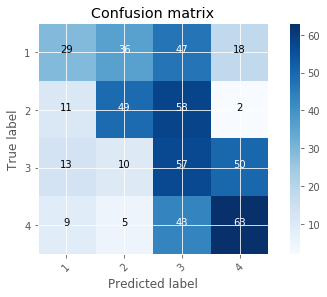

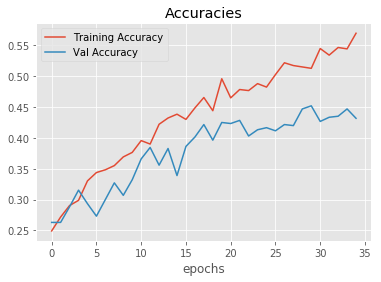

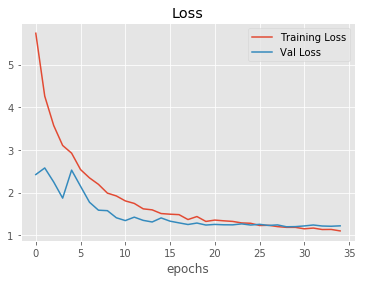

In [11]:
# Conv2D + LSTM

model = Sequential()
model.add(Conv2D(40, kernel_size=(3,3), activation='relu', data_format='channels_last', input_shape=(512, 22, 1))) 
model.add(Conv2D(40, kernel_size=(1,22), activation='relu') ) 
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(60,1)))
model.add(Flatten())
model.add(Dropout(0.65))
model.add(Dense(4, activation='softmax'))#, kernel_regularizer=regularizers.l2(0.05)))
model.compile(optimizer = 'adam',
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])
model.summary()
hist = model.fit(traindata2d,train_labels_sliced,epochs=35,validation_split=0.25,batch_size=100)
test_score = model.evaluate(testdata2d, test_labels_sliced, batch_size=32)
print "Test Score: {}".format(test_score)
test_predict = model.predict(testdata2d, batch_size=32)
cm = confusion_matrix(np.argmax(test_labels_sliced,axis=1),np.argmax(test_predict,axis=1))
unique, count = np.unique(np.argmax(test_labels_sliced,axis=1),return_counts=True)
print count 
plt.figure(0)
plot_confusion_matrix(cm, classes=["1","2","3","4"])
print np.argmax(test_predict,axis=1).shape
plt.figure(1)
plot_hist([hist.history['acc'],hist.history['val_acc']],['Training Accuracy','Val Accuracy'],title='Accuracies')
plt.figure(2)
plot_hist([hist.history['loss'],hist.history['val_loss']],['Training Loss','Val Loss'],title='Loss')

In [ ]:
#Deeper CNN + LSTM (Golmohammadi paper)
model = Sequential()
model.add(Conv2D(16, kernel_size=(22,1), activation='relu', data_format='channels_last', input_shape=(512, 22, 1)))